In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score,roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve
import warnings
import plotly.offline as py
py.init_notebook_mode(connected= True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
dataset = pd.read_excel("loan.xlsx")
dataset.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,M,50.750000,0.585,owner,given,unemploye,unemploye,0,0,f,given,145,0,reject
1,M,19.670000,10.000,rent,not_given,labourer,governmen,0,0,t,given,140,0,reject
2,F,52.830002,15.000,owner,given,creative_,private_s,5,14,f,given,0,2200,accept
3,M,22.670000,2.540,rent,not_given,creative_,governmen,2,0,f,given,0,0,accept
4,M,29.250000,13.000,owner,given,driver,governmen,0,0,f,given,228,0,reject


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              429 non-null    object 
 1   Age              429 non-null    float64
 2   Time_at_address  429 non-null    float64
 3   Res_status       429 non-null    object 
 4   Telephone        429 non-null    object 
 5   Occupation       429 non-null    object 
 6   Job_status       429 non-null    object 
 7   Time_employed    429 non-null    int64  
 8   Time_bank        429 non-null    int64  
 9   Liab_ref         429 non-null    object 
 10  Acc_ref          429 non-null    object 
 11  Home_Expn        429 non-null    int64  
 12  Balance          429 non-null    int64  
 13  Decision         429 non-null    object 
dtypes: float64(2), int64(4), object(8)
memory usage: 47.0+ KB


In [4]:
null_feat = pd.DataFrame(len(dataset['Decision']) - dataset.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'], opacity= 0.8, marker = dict(color = 'lightgrey', 
            line= dict(color= '#000000', width =1.5)))

layout = dict(title = "Missing Values")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [5]:
Positive_Decision = dataset[(dataset['Decision'] != 0)]
Negative_Decision = dataset[(dataset['Decision'] == 0)]

trace= go.Pie(labels= ['Negative_Decision', 'Positive_Decision'], values = dataset['Decision'].value_counts(),
             textfont=dict(size=15), opacity = 0.8,
             marker = dict(colors=['blue', 'yellow'],
                          line= dict(color='#000000', width=1.5)))

layout= dict(title= 'Distribution of decision variable')

fig = dict(data =[trace], layout=layout)
py.iplot(fig)

In [6]:
missing_df = pd.DataFrame({
    "Columns": dataset.columns[dataset.isnull().sum()>0],
    "Values": dataset[dataset.columns[dataset.isnull().sum()>0]].isnull().sum()/len(dataset)*100
})
missing_df = missing_df.reset_index(drop=True)
missing_df
dataset.isnull().sum()/len(dataset)*100

Sex                0.0
Age                0.0
Time_at_address    0.0
Res_status         0.0
Telephone          0.0
Occupation         0.0
Job_status         0.0
Time_employed      0.0
Time_bank          0.0
Liab_ref           0.0
Acc_ref            0.0
Home_Expn          0.0
Balance            0.0
Decision           0.0
dtype: float64

In [7]:
var_target = ['Decision']
var_categorical = ['Sex', 'Res_status', 'Telephone', 'Occupation', 'Job_status','Liab_ref', 'Acc_ref']
var_numerical = list(set(dataset.columns) - set(var_categorical) - set(var_target))
dataset[var_categorical].nunique()

Sex            2
Res_status     2
Telephone      2
Occupation    12
Job_status     7
Liab_ref       2
Acc_ref        2
dtype: int64

In [8]:
def top_labels(dataset, col, max_col):
    top = list(dataset[col].value_counts().sort_values(ascending=False).head(max_col).index)
    print("Top Labels: ", top)
    for categories in top:
        dataset[col+ "_" +str(categories)]=np.where(dataset[col]==categories,1,0)
        print(col + "_" + str(categories))
    return top

In [9]:
dataset["Occupation"].value_counts()

creative_    92
office_st    49
productio    45
labourer     42
guard_etc    35
sales        31
unemploye    30
manager      28
professio    21
executive    20
semi_pro     20
driver       16
Name: Occupation, dtype: int64

In [10]:
top_labels_emp = top_labels(dataset, 'Occupation', 9)
dataset = dataset.drop(['Occupation'], axis = 1)

Top Labels:  ['creative_', 'office_st', 'productio', 'labourer', 'guard_etc', 'sales', 'unemploye', 'manager', 'professio']
Occupation_creative_
Occupation_office_st
Occupation_productio
Occupation_labourer
Occupation_guard_etc
Occupation_sales
Occupation_unemploye
Occupation_manager
Occupation_professio


In [11]:
top_labels_emp = top_labels(dataset, 'Job_status', 4)
dataset = dataset.drop(['Job_status'], axis = 1)

Top Labels:  ['private_s', 'governmen', 'self_empl', 'unemploye']
Job_status_private_s
Job_status_governmen
Job_status_self_empl
Job_status_unemploye


In [12]:
var_categorical = list(set(var_categorical) - set(['Occupation','Job_status']))

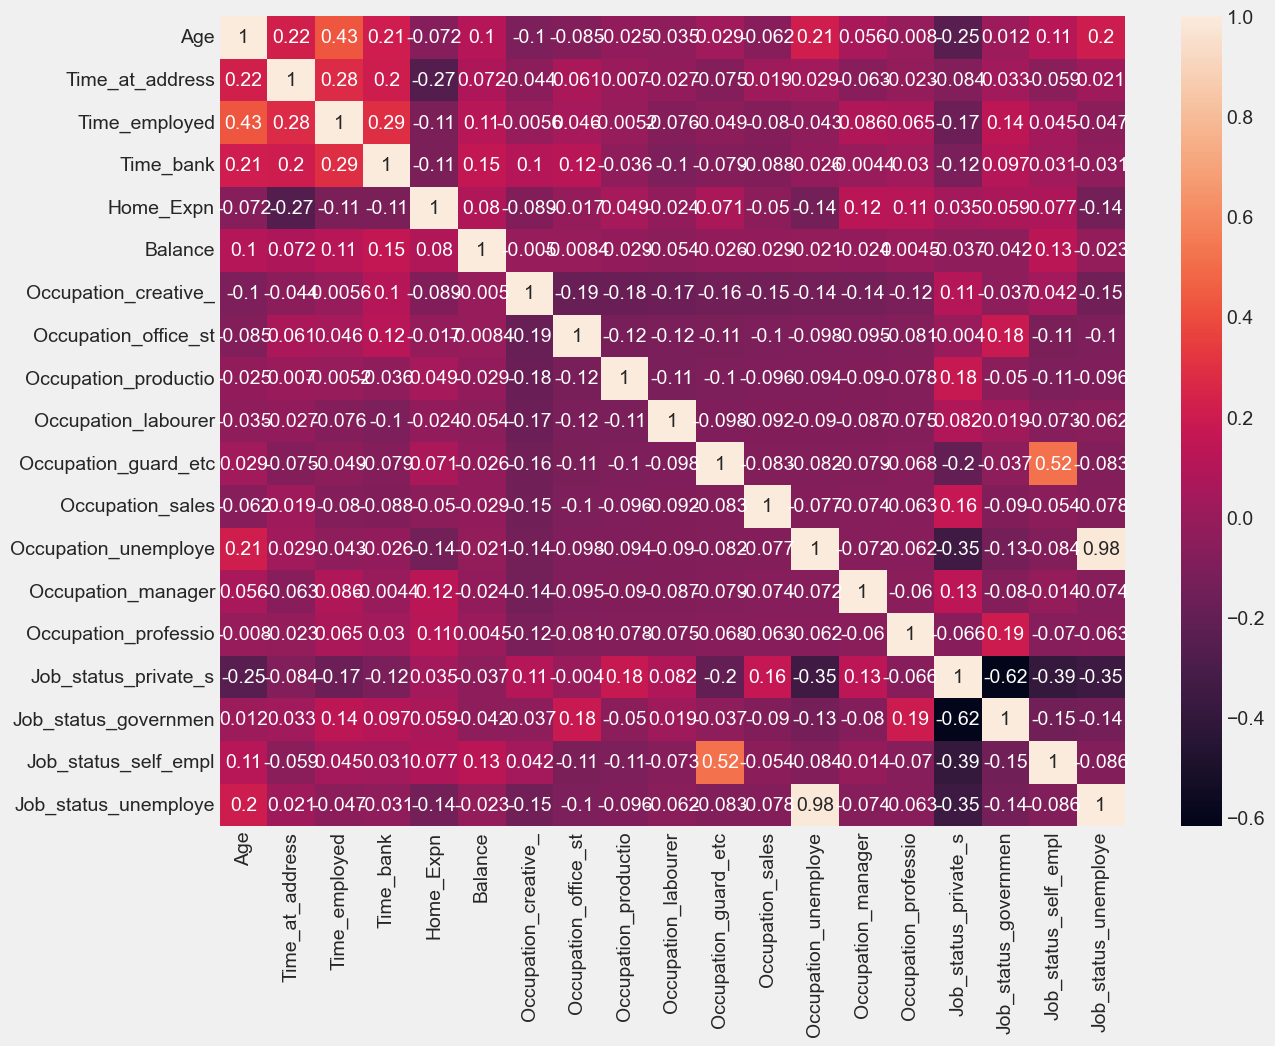

In [13]:
plt.figure(figsize=(13, 10))
dataset = pd.DataFrame(dataset)

corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['Job_status_unemploye']


C:\Users\pkala\AppData\Local\Temp\ipykernel_27500\3186150596.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [15]:
categorical_col = var_categorical
for column in dataset.columns:
    if dataset[column].dtype == object and len(dataset[column].unique()) <= 50:
        categorical_col.append(column)
dataset['Decision'] = dataset.Decision.astype("category").cat.codes

In [16]:
 dataset['Decision'] = dataset.Decision.astype("category").cat.codes

In [17]:
categorical_col.remove('Decision')

In [18]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in categorical_col:
    dataset[column] = label.fit_transform(dataset[column])

In [19]:
from sklearn.model_selection import train_test_split

X = dataset.drop('Decision', axis=1)
y = dataset.Decision

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    131.0  169.0       1.0      300.0         300.0
_______________________________________________
Confusion Matrix: 
 [[131   0]
 [  0 169]]

Test Result:
Accuracy Score: 68.99%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.672131   0.705882  0.689922    0.689007      0.689922
recall      0.672131   0.705882  0.689922    0.689007      0.689922
f1-score    0.672131   0.705882  0.689922    0.689007      0.689922
support    61.000000  68.000000  0.689922  129.000000    129.000000
_______________________________________________
Confusion

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'})
Train Result:
Accuracy Score: 79.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.826923    0.770408      0.79    0.798666      0.795086
recall       0.656489    0.893491      0.79    0.774990      0.790000
f1-score     0.731915    0.827397      0.79    0.779656      0.785703
support    131.000000  169.000000      0.79  300.000000    300.000000
_______________________________________________
Confusion Matrix: 
 [[ 86  45]
 [ 18 151]]

Test Result:
Accuracy Score: 69.77%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.711538   0.688312  0.697674    0.699925      0.699295
recall      0.

In [23]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(dataset.columns)
features.remove("Decision")

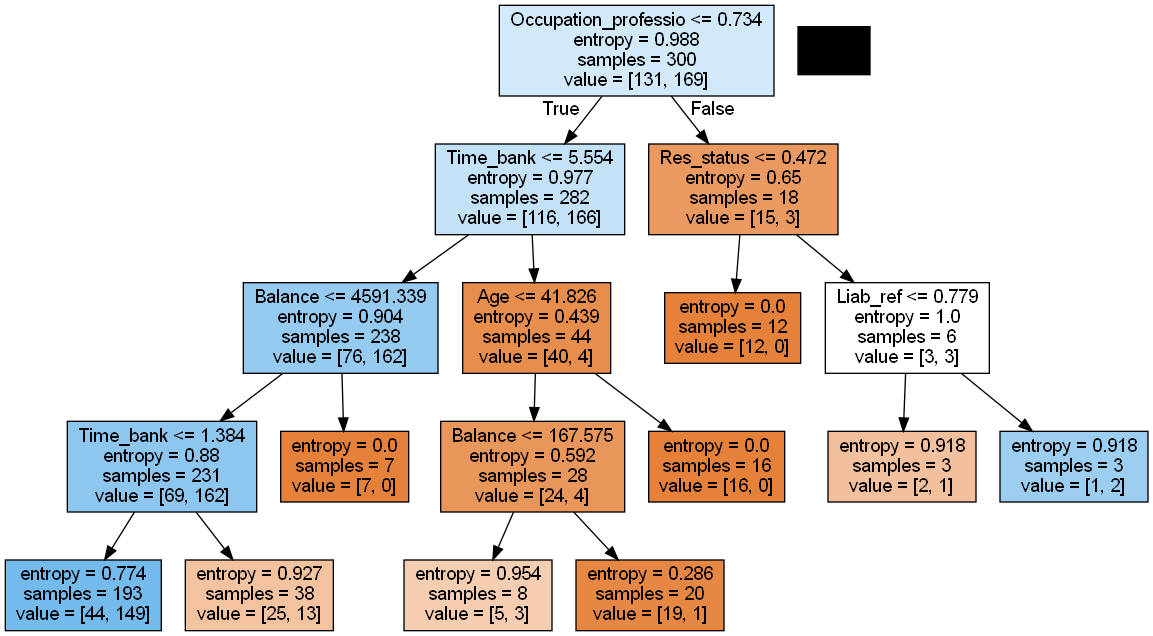

In [24]:
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    131.0  169.0       1.0      300.0         300.0
_______________________________________________
Confusion Matrix: 
 [[131   0]
 [  0 169]]

Test Result:
Accuracy Score: 74.42%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.759259   0.733333  0.744186    0.746296      0.745593
recall      0.672131   0.808824  0.744186    0.740477      0.744186
f1-score    0.713043   0.769231  0.744186    0.741137      0.742662
support    61.000000  68.000000  0.744186  129.000000    129.000000
_______________________________________________
Confusion